# Cognitive Data with MLPClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from utils import make_machine_learning_df, plot_roc_curve, plot_patient_age_gender

In [69]:
%matplotlib inline 
sns.set() # set seaborn styles, not sure I need to run %matplotlib inline 

In [70]:
# sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, confusion_matrix

---

## data prep
create training data for deomgraphics, cognitive functioning scrores, and perio info  
NHANES cognitive data downloaded from https://www.icpsr.umich.edu/web/about/cms/3625/

In [71]:
adjusted_df = make_machine_learning_df() # NB: the data is duplicated to reflect surview weights
len(adjusted_df)

8554

---

## scale/standardize data

In [6]:
# standarize train_df values
scaler = StandardScaler() # creates z-scores

# trainform data
standardize_cols = ['age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6']
scaled_data = scaler.fit_transform(adjusted_df[standardize_cols].to_numpy())

# put scaled data in dataframe
scaled_df = pds.DataFrame(scaled_data, columns=standardize_cols, index=adjusted_df.index)
scaled_df = pds.concat([adjusted_df[['female', 'low_global_re']], scaled_df], axis=1)

In [7]:
scaled_df.female.value_counts()

0    5388
1    3166
Name: female, dtype: int64

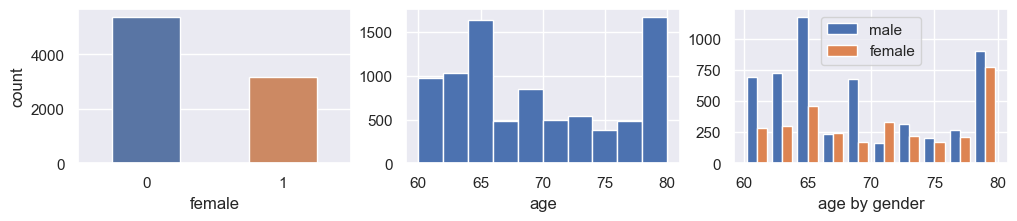

In [8]:
plot_patient_age_gender(adjusted_df).show()

---

## split train/test datasets

In [9]:
X = scaled_df.drop('low_global_re', axis=1)
y = scaled_df['low_global_re']

In [10]:
# X.head()

In [11]:
# create test and train datasets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X,
        y,
        test_size=0.3, 
        random_state=42, 
        stratify=y
    )

---

## MLPClassifier

In [12]:
X_train.columns

Index(['female', 'age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5',
       'pct_teeth_gt_6'],
      dtype='object')

In [13]:
clf = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=(4,), activation='relu', solver='lbfgs')
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(4,), max_iter=2000, random_state=42,
              solver='lbfgs')

In [14]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[::,1]

In [15]:
# y_pred

In [16]:
report = classification_report(y_test, y_pred, zero_division=0)
auc_score = round(roc_auc_score(y_test, y_proba), 2)

In [17]:
# print(f'AUC: {auc_score}')
# print(report)

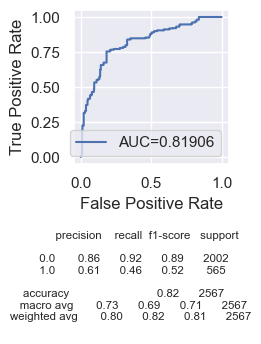

In [18]:
plot_roc_curve(y_test, y_pred, y_proba).show()

---

## SHAP values  
https://github.com/slundberg/shap

In [19]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(clf.predict, X_test)
shap_values = explainer(X_test)

In [20]:
# shap_values.feature_names

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


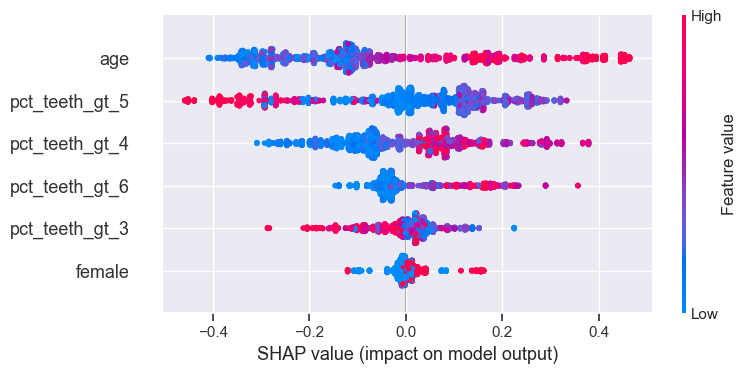

In [21]:
shap.summary_plot(shap_values)

In [22]:
shap.initjs()
# shap.plots.force(shap_values)

In [23]:
# shap.plots.bar(shap_values)

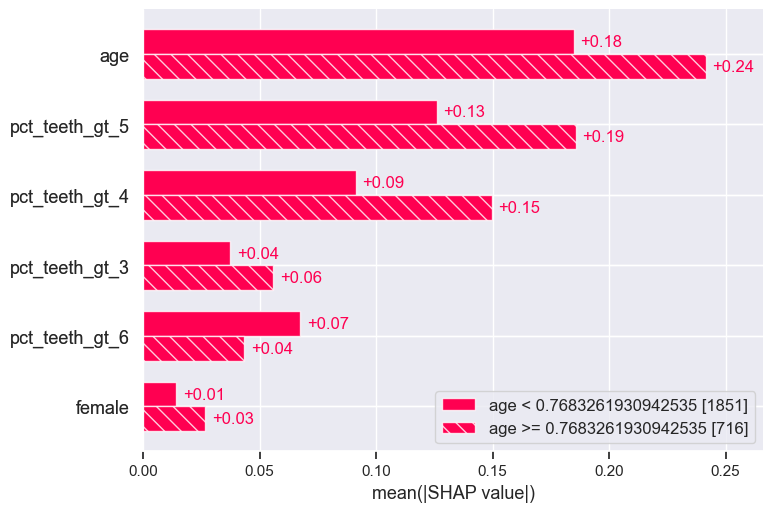

In [24]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

# Experiment with rebalancing

The dataset has many more negative cases (0) than positive ones (1).  
Test is rebalancing will help.

In [25]:
pds.DataFrame(y).value_counts()

low_global_re
0.0              6670
1.0              1884
dtype: int64

In [26]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)

## random over sampling

In [27]:
X_ros, y_ros = ros.fit_resample(X, y)
pds.DataFrame(y_ros).value_counts()

low_global_re
0.0              6670
1.0              6670
dtype: int64

In [28]:
# create test and train datasets
X_train_ros, X_test_ros, y_train_ros, y_test_ros = \
    train_test_split(
        X_ros,
        y_ros, 
        test_size=0.3, 
        random_state=42, 
        stratify=y_ros
    )

In [29]:
clf_ros = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=(4,), activation='relu', solver='lbfgs')
clf_ros.fit(X_train_ros, y_train_ros)

MLPClassifier(hidden_layer_sizes=(4,), max_iter=2000, random_state=42,
              solver='lbfgs')

In [30]:
y_pred_ros = clf_ros.predict(X_test_ros)
y_proba_ros = clf_ros.predict_proba(X_test_ros)[::,1]

In [31]:
auc_score = round(roc_auc_score(y_test_ros, y_proba_ros), 5)
report = classification_report(y_test_ros, y_pred_ros, zero_division=0)

In [32]:
print(f'AUC: {auc_score}')
print(report)

AUC: 0.84451
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      2001
         1.0       0.78      0.78      0.78      2001

    accuracy                           0.78      4002
   macro avg       0.78      0.78      0.78      4002
weighted avg       0.78      0.78      0.78      4002



In [33]:
confusion_matrix(y_test_ros, y_pred_ros)

array([[1552,  449],
       [ 447, 1554]])

In [34]:
explainer_ros = shap.Explainer(clf_ros.predict, X_test_ros)
shap_values_ros = explainer_ros(X_test_ros)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


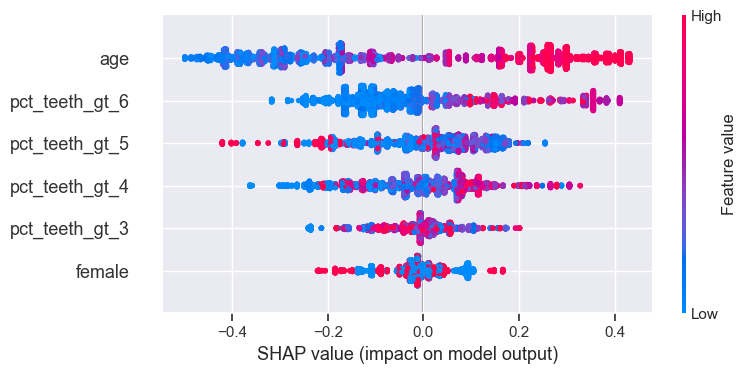

In [35]:
shap.summary_plot(shap_values_ros)

## random under sampling

In [36]:
X_rus, y_rus = rus.fit_resample(X, y)
pds.DataFrame(y_rus).value_counts()

low_global_re
0.0              1884
1.0              1884
dtype: int64

In [37]:
# create test and train datasets
X_train_rus, X_test_rus, y_train_rus, y_test_rus = \
    train_test_split(
        X_rus,
        y_rus, 
        test_size=0.3, 
        random_state=42, 
        stratify=y_rus
    )

In [38]:
clf_rus = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=(4,), activation='relu', solver='lbfgs')
clf_rus.fit(X_train_rus, y_train_rus)

MLPClassifier(hidden_layer_sizes=(4,), max_iter=2000, random_state=42,
              solver='lbfgs')

In [39]:
y_pred_rus = clf_rus.predict(X_test_rus)
y_proba_rus = clf_rus.predict_proba(X_test_rus)[::,1]

In [40]:
auc_score = round(roc_auc_score(y_test_rus, y_proba_rus), 5)
report = classification_report(y_test_rus, y_pred_rus, zero_division=0)

In [41]:
print(f'AUC: {auc_score}')
print(report)

AUC: 0.86604
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       566
         1.0       0.80      0.81      0.81       565

    accuracy                           0.80      1131
   macro avg       0.80      0.80      0.80      1131
weighted avg       0.80      0.80      0.80      1131



In [42]:
confusion_matrix(y_test_rus,y_pred_rus)

array([[453, 113],
       [108, 457]])

In [43]:
explainer_rus = shap.Explainer(clf_rus.predict, X_test_rus)
shap_values_rus = explainer_ros(X_test_rus)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


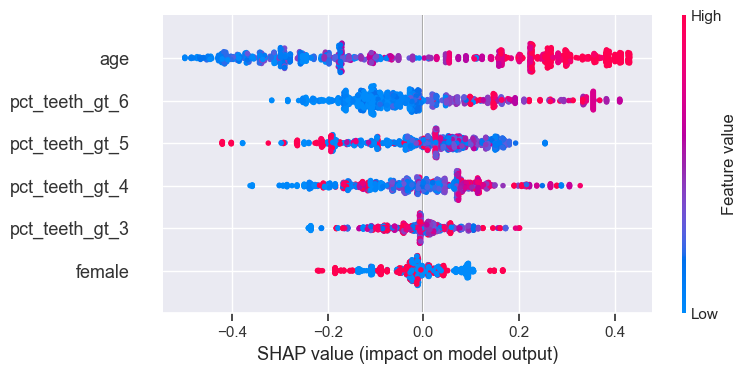

In [44]:
shap.summary_plot(shap_values_rus)

---

## predict using non-adjusted (raw) data

In [45]:
data_cols=['SEQN', 'female', 'ridageyr', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6', 'low_global_re']

In [46]:
raw_df = pds.read_table('../refined_data/merged_data.tsv', usecols=data_cols, index_col='SEQN')
raw_df = raw_df.rename(columns={'ridageyr': 'age'})
len(raw_df)

313

---

## scale/standardize data

In [47]:
# standarize train_df values
raw_scaler = StandardScaler() # creates z-scores

# trainform data
standardize_cols = ['age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6']
raw_scaled_data = raw_scaler.fit_transform(raw_df[standardize_cols].to_numpy())

# put scaled data in dataframe
raw_scaled_df = pds.DataFrame(raw_scaled_data, columns=standardize_cols, index=raw_df.index)
raw_scaled_df = pds.concat([raw_df[['female', 'low_global_re']], raw_scaled_df], axis=1)

In [48]:
# raw_scaled_df.head()

In [49]:
raw_scaled_df.female.value_counts()

0    207
1    106
Name: female, dtype: int64

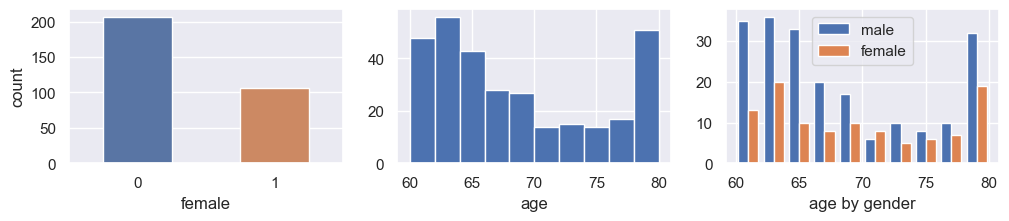

In [50]:
plot_patient_age_gender(raw_df).show()

---

## split train/test datasets

In [51]:
X_raw = raw_scaled_df.drop('low_global_re', axis=1)
y_raw = raw_scaled_df['low_global_re']

In [52]:
# X_raw.head()

In [53]:
# create test and train datasets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = \
    train_test_split(
        X_raw,
        y_raw,
        test_size=0.3, 
        random_state=42, 
        stratify=y_raw
    )

---

## MLPClassifier

In [54]:
X_train_raw.columns

Index(['female', 'age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5',
       'pct_teeth_gt_6'],
      dtype='object')

In [55]:
clf_raw = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=(4,), activation='relu', solver='lbfgs')
clf_raw.fit(X_train_raw, y_train_raw)

MLPClassifier(hidden_layer_sizes=(4,), max_iter=2000, random_state=42,
              solver='lbfgs')

In [56]:
y_pred_raw = clf.predict(X_test_raw)
y_proba_raw = clf.predict_proba(X_test_raw)[::,1]

In [57]:
# y_pred

In [58]:
report_raw = classification_report(y_test_raw, y_pred_raw, zero_division=0)
auc_score_raw = round(roc_auc_score(y_test_raw, y_proba_raw), 2)

In [59]:
# print(f'AUC: {auc_score_raw}')
# print(report_raw)

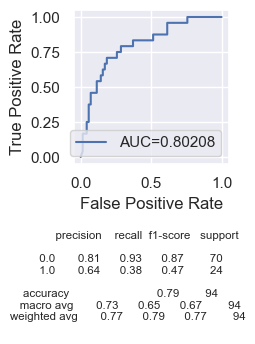

In [60]:
plot_roc_curve(y_test_raw, y_pred_raw, y_proba_raw).show()

---

## SHAP values  
https://github.com/slundberg/shap

In [61]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer_raw = shap.Explainer(clf_raw.predict, X_test_raw)
shap_values_raw = explainer(X_test_raw)

In [62]:
# shap_values.feature_names

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


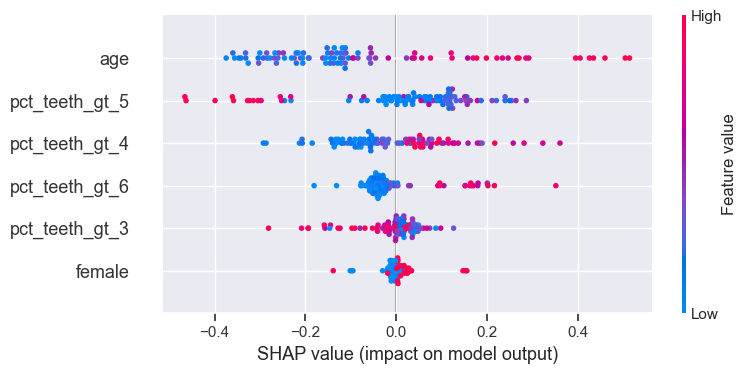

In [63]:
shap.summary_plot(shap_values_raw)

In [64]:
shap.initjs()
# shap.plots.force(shap_values)

In [65]:
# shap.plots.bar(shap_values)

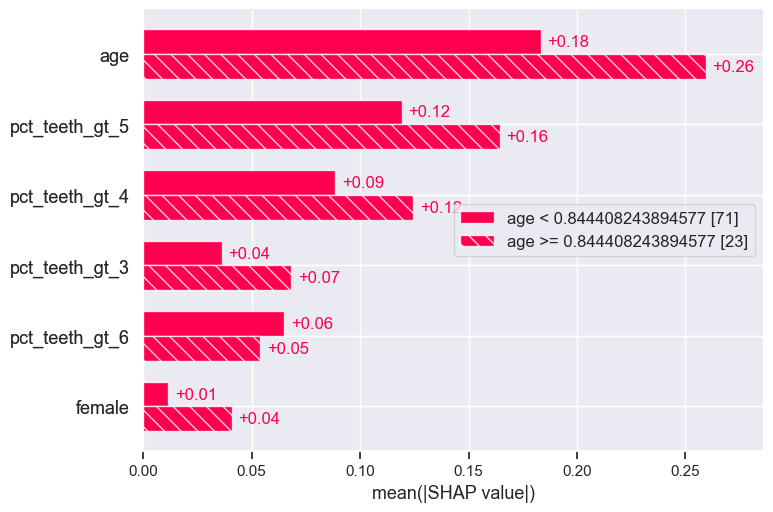

In [66]:
shap.plots.bar(shap_values_raw.cohorts(2).abs.mean(0))